# Bootstrap

This notebook will implement both percentile and studentized bootstrap methods and compare them with the t-test to see if we can get some gains when there are not enough samples

In [117]:
from __future__ import annotations
from IPython import get_ipython
import os

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
from dataclasses import dataclass

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

import scipy.stats as stats

from typing import Optional, Any, Tuple
import numpy.typing as npt
from sklearn.metrics import auc

In [118]:
confidence = 0.95

def assign_random_variant(df, variant_col, random_seed=42, num_samples=None, replace=True):
    np.random.seed(random_seed)
    if num_samples:
        df = df.sample(num_samples, replace=replace)
    df[variant_col] = np.random.choice(['control', 'treatment'], size=df.shape[0], p=[0.5, 0.5])
    if df[variant_col].nunique() < 2:
        print(df)
    return df

In [141]:
# Run a t-test
def t_test_mean_diff(df, variant_col, value_col, variant1="treatment", variant2="control", 
                     alpha=0.05, alternative='two-sided'):
    control_values = df[df[variant_col] == variant1][value_col]
    treatment_values = df[df[variant_col] == variant2][value_col]
    t_statistic, p_value = stats.ttest_ind(control_values, treatment_values, alternative=alternative)
    if math.isnan(p_value):
        t_statistic = 0
        if alternative == "two-sided":
            p_value = 1
        else:
            p_value = 0.5
    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha
    
    return t_statistic, p_value, reject_null


In [142]:

# Bootstrap tests: Percentile and Effron-Tibshirani

def get_frequency_tables(data, variant_col, value_col, count_col="user_id"):
    frequency_table = (data
                           .groupby([variant_col, value_col])[count_col]
                           .count()
                           .reset_index()
                           .rename(columns={count_col: "count"})
                      )
    variants = frequency_table["variant"].unique()
    variant_dict = {}
    for v in variants:
        variant_dict[v] = Variant(v, frequency_table.loc[frequency_table["variant"]==v])
        variant_dict[v].frequency_table = variant_dict[v].frequency_table.drop(columns="variant")
    
    return variant_dict

@dataclass
class Variant:
    tag: str
    frequency_table: pd.DataFrame

    def add_frequency_table(
        self,
        frequency: pd.DataFrame,
    ):
        self.frequency_table = frequency


def redraw(count: npt.NDArray[Any], n: int = 1_000) -> npt.NDArray[Any]:
    return np.random.multinomial(count.sum(), count / count.sum(), size=n)

def expected(x: npt.NDArray[Any], counts: npt.NDArray[Any]) -> npt.NDArray[Any]:
    return (counts * x).sum(axis=1) / counts.sum(axis=1)

@dataclass
class CountsTable:
    counts: npt.NDArray[Any]
    values: pd.DataFrame

    @classmethod
    def from_frequency(cls, freq: pd.DataFrame) -> CountsTable:
        return cls(np.array([freq["count"].values]), freq.drop("count", axis=1))

    def unbias(self) -> CountsTable:
        # Shift values by removing a constant so the first draw in the CountsTable has mean = 0
        if len(self.counts) > 1:
            raise RuntimeError("Can only unbias CountsTable with only one count")
        if len(self.values.values.T) > 1:
            raise RuntimeError("Can only unbias CountsTable with only one value")
        return CountsTable(
            self.counts, self.values - expected(self.values.values.T, self.counts)[0]
        )

    def redraw(self, n: int = 1) -> CountsTable:
        # Redraw `n` times from the first column of counts
        return CountsTable(redraw(self.counts[0], n), self.values)

decimal_places = lambda x: -int(math.floor(math.log10(abs(x)))) + 1
        
        
def t_statistic(count_a: CountsTable, count_b: CountsTable) -> Tuple[Any, Any, Any]:
    mean_a = expected(count_a.values.values.T, count_a.counts)
    mean_b = expected(count_b.values.values.T, count_b.counts)
    var_a = expected(count_a.values.values.T**2, count_a.counts) - mean_a**2
    var_b = expected(count_b.values.values.T**2, count_b.counts) - mean_b**2
    n_a = count_a.counts.sum(axis=1)
    n_b = count_b.counts.sum(axis=1)
    with np.errstate(divide='ignore'):
        t_statistic = (mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)
    return t_statistic, mean_a, mean_b
        
    
def t_statistic_bootstrap(
    control_freq: pd.DataFrame,
    treatment_freq: pd.DataFrame,
):
    control = CountsTable.from_frequency(control_freq)
    treatment = CountsTable.from_frequency(treatment_freq)
    stats_base = t_statistic(treatment, control)
    t_base = stats_base[0][0]
    c_redraw = control.unbias().redraw(1_000)
    t_redraw = treatment.unbias().redraw(1_000)
    stats_bootstrap = t_statistic(t_redraw, c_redraw)
    t_bootstrap = stats_bootstrap[0]
    return t_base, t_bootstrap

def bootstrap_mean(frequency):
    count = CountsTable.from_frequency(frequency)
    c_redraw = count.redraw(1_000)
    c_mean = c_redraw.counts @ c_redraw.values.values / sum(c_redraw.counts.T)[0]
    c_mean_df = pd.DataFrame(data=c_mean, columns=count.values.columns)
    return c_mean_df


def et_test(variants: dict[str, Variant], confidence: float = confidence, 
            alternative: str = "two-sided"):
    variant_a, variant_b = variants["control"], variants["treatment"]
    t_base, t_bootstrap = t_statistic_bootstrap(
        variant_a.frequency_table, variant_b.frequency_table
    )
    p_value_right = np.mean(t_bootstrap > t_base)
    p_value_left = np.mean(t_bootstrap < t_base)
    p_value_twosided = np.mean(abs(t_bootstrap) > abs(t_base))

    # Calculate the p-value
    if alternative == 'two-sided':
        p_value = p_value_twosided
    elif alternative == 'less':
        p_value = p_value_left
    elif alternative == 'greater':
        p_value = p_value_right
    else:
        raise ValueError("Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'.")

    # Determine whether to reject the null hypothesis
    reject_null = p_value < 1-confidence

    return p_value, reject_null

def percentile_test(
    variants: dict[str, Variant], show_plots: bool = False, confidence: float = 0.95, alternative="two-sided"
):
    histogram = {}
    variant_a, variant_b = variants["control"], variants["treatment"]
    for variant in [variant_a, variant_b]:
        bootstrap = bootstrap_mean(variant.frequency_table)
        histogram[variant.tag] = bootstrap.iloc[:,0]

    p_value_right = np.mean(histogram[variant_a.tag] >= histogram[variant_b.tag], axis=0)
    p_value_left = np.mean(histogram[variant_b.tag] >= histogram[variant_a.tag], axis=0)
    
    # Calculate the p-value
    if alternative == 'two-sided':
        p_value = np.nan
    elif alternative == 'less':
        p_value = p_value_left
    elif alternative == 'greater':
        p_value = p_value_right
    else:
        raise ValueError("Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'.")

    # Determine whether to reject the null hypothesis
    reject_null = p_value < 1-confidence

    return p_value, reject_null

In [143]:
# Define the function to apply the z-test to multiple dataframes
def run_test_mean_diff_multiple(df, variant_col, value_col, number_of_tests=100, 
                                num_samples=None, alternative="two-sided", effect=0):
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame()
    
    # Iterate over pairs of dataframes
    for i in range(number_of_tests):
        random_df = assign_random_variant(df, variant_col, random_seed=i, num_samples=num_samples)
        random_df[value_col] = np.where(random_df[variant_col]=="treatment", 
                                        random_df[value_col]*(1+effect), 
                                        random_df[value_col])

        # Apply the t-test to the pair of dataframes
        t_score, t_p_value, t_reject_null = t_test_mean_diff(random_df, variant_col=variant_col, alpha=1-confidence,
                                                             value_col=value_col, alternative=alternative)
        
        
        # Apply the percentile bootstrap test to the pair of dataframes
        variant_dict = get_frequency_tables(random_df, variant_col="variant", value_col="total_sales")
        
        percentile_p_value, percentile_reject_null = percentile_test(variant_dict, alternative=alternative)
        et_p_value, et_reject_null = et_test(variant_dict, alternative=alternative)
        
        # Add the results to the DataFrame
        this_results = pd.DataFrame({'test_number': i,
                                        't_score': t_score,
                                        't_p_value': t_p_value,
                                        't_reject_null': t_reject_null,
                                        'percentile_p_value': percentile_p_value,
                                        'percentile_reject_null': percentile_reject_null,
                                        'et_p_value': et_p_value,
                                        'et_reject_null': et_reject_null,},
                                   index=[0])
        results_df = pd.concat([results_df, this_results])
    
    # Return the results DataFrame
    return results_df

In [3]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/2019-Oct.csv")

events_df['time'] = pd.to_datetime(events_df['event_time'])
events_df['date'] = events_df['time'].dt.date
events_df["sales"] = np.where(events_df["event_type"]=="purchase", events_df["price"], 0)
events_df = pd.get_dummies(data=events_df, columns=["event_type"])
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,True,False,False,False
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,True,False,False,False
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,True,False,False,False
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,True,False,False,False
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,True,False,False,False


In [6]:
# Transform to user-based data
users_df = events_df.groupby("user_id").agg(
    {
        "user_id":                      ['size'],
        "sales":                        ['sum'],
        "event_type_view":              ["sum", "max"],
        "event_type_cart":              ["sum", "max"],
        "event_type_remove_from_cart":  ["sum", "max"],
        "event_type_purchase":          ["sum", "max"],
        "date":                         ["min", "max"]
    }
)
users_df.columns = ['_'.join(col).strip() for col in users_df.columns.values]
users_df = users_df.rename(columns={
    'user_id_size': 'num_events', 'sales_sum': 'total_sales', 
    'event_type_view_sum': 'total_views', 'event_type_view_max': 'has_view',
    'event_type_cart_sum': 'total_cart', 'event_type_cart_max': 'has_cart',
    'event_type_remove_from_cart_sum': 'total_remove_from_cart', 'event_type_remove_from_cart_max': 'has_remove_from_cart',
    'event_type_purchase_sum': 'total_purchases', 'event_type_purchase_max': 'has_purchases',
}).reset_index()
users_df = assign_random_variant(users_df, variant_col="variant")


## Tests

We're going to try to see how the p-values behave for the standard t-test and the percentile and studentized bootstrap. The expectation a priori is that with little samples, the bootstraps will be more accurate, with the studentized being even better than the percentile, because they provide a more accurate model of the theoretical distribution of the sample mean. As the number of samples get greater and the CLT is more aplicable, we expect that all methods behave similarly and that the computational cost of running the bootstrap will not be worth it.

### AA test

In [156]:
experiments = 1000
samples = [50, 200, 1000, 5000]
p_values_AA = pd.DataFrame()

for s in samples:
    this_p_values = run_test_mean_diff_multiple(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=experiments, num_samples=s, alternative="greater")
    this_p_values = this_p_values.reset_index(drop=True)
    this_p_values["samples"] = s 
    p_values_AA = pd.concat([p_values_AA, this_p_values])

p_values_AA

,test_number,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null,samples
0,0,-0.375731,0.645614,False,0.673,False,0.525,False,50
1,1,-0.996016,0.837882,False,0.859,False,0.891,False,50
2,2,0.698466,0.244128,False,0.238,False,0.254,False,50
3,3,0.780112,0.219577,False,0.233,False,0.188,False,50
4,4,1.188838,0.120176,False,0.118,False,0.030,True,50
...,...,...,...,...,...,...,...,...,...
995,995,0.598991,0.274603,False,0.271,False,0.261,False,5000
996,996,1.129331,0.129406,False,0.120,False,0.137,False,5000
997,997,-0.337352,0.632067,False,0.620,False,0.625,False,5000
998,998,1.201445,0.114818,False,0.106,False,0.101,False,5000


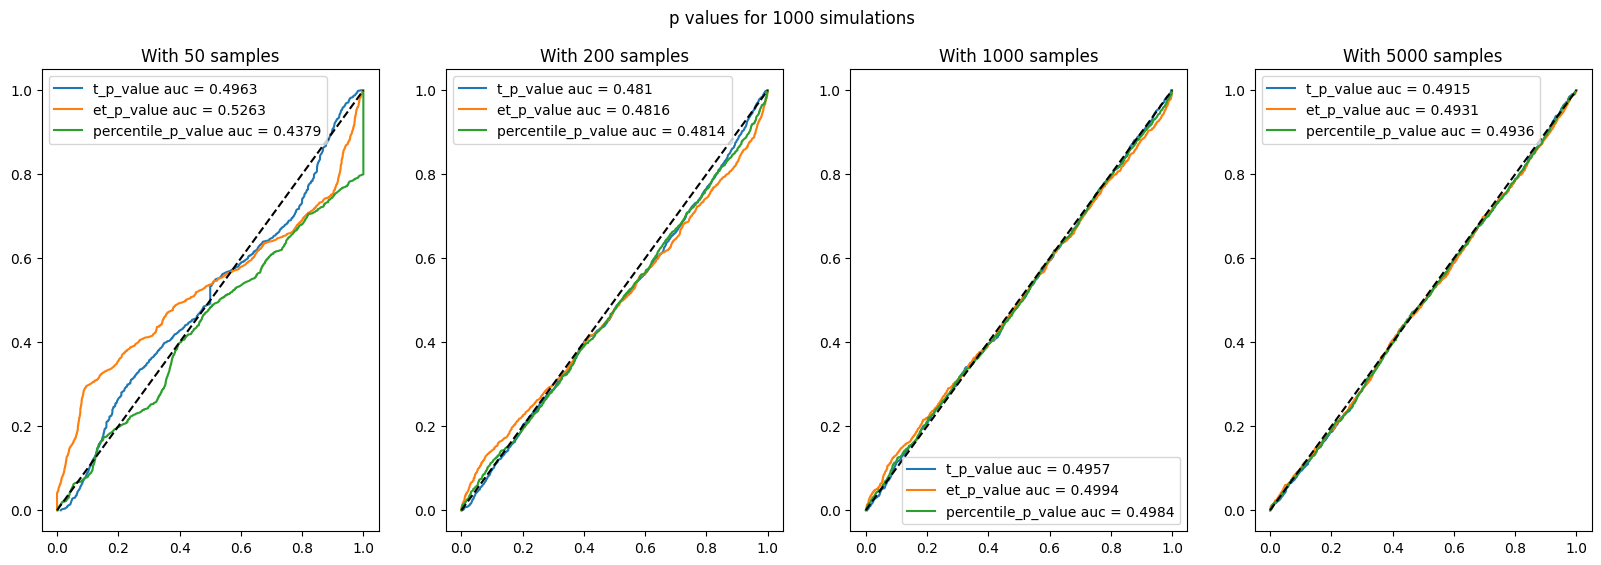

In [162]:
fig, ax = plt.subplots(1,len(samples), figsize=(20, 6))
fig.suptitle(f"p values for {experiments} simulations")

for i, s in enumerate(samples):
    data = p_values_AA[p_values_AA["samples"]==s]
    for t in ["t_p_value", "et_p_value", "percentile_p_value"]:
        auc_value = auc(sorted(data[t]), np.linspace(0, 1, experiments))
        ax[i].plot(sorted(data[t]), np.linspace(0, 1, experiments), label=f"{t} auc = {round(auc_value, 4)}")

    ax[i].set_title(f"With {s} samples")
    ax[i].legend()
    ax[i].plot([0,1],[0,1], '--k')
    ax[i].axvline(0.05, ls='--', color="red")

### AB test

##### I. Effect 10%

In [166]:
experiments = 1000
samples = [50, 200, 1000, 5000]
p_values_AB_i = pd.DataFrame()

for s in samples:
    this_p_values = run_test_mean_diff_multiple(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=experiments, num_samples=s, alternative="greater", effect=.1)
    this_p_values = this_p_values.reset_index(drop=True)
    this_p_values["samples"] = s 
    p_values_AB_i = pd.concat([p_values_AB_i, this_p_values])

p_values_AB_i

,test_number,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null,samples
0,0,-0.309236,0.620760,False,0.673,False,0.657,False,50
1,1,-0.927425,0.820827,False,0.844,False,0.861,False,50
2,2,0.769903,0.222565,False,0.210,False,0.230,False,50
3,3,0.850208,0.199715,False,0.179,False,0.177,False,50
4,4,1.188838,0.120176,False,0.118,False,0.030,True,50
...,...,...,...,...,...,...,...,...,...
995,995,1.135754,0.128057,False,0.141,False,0.121,False,5000
996,996,1.782436,0.037369,True,0.036,True,0.032,True,5000
997,997,0.219980,0.412948,False,0.395,False,0.389,False,5000
998,998,1.736467,0.041271,True,0.041,True,0.030,True,5000


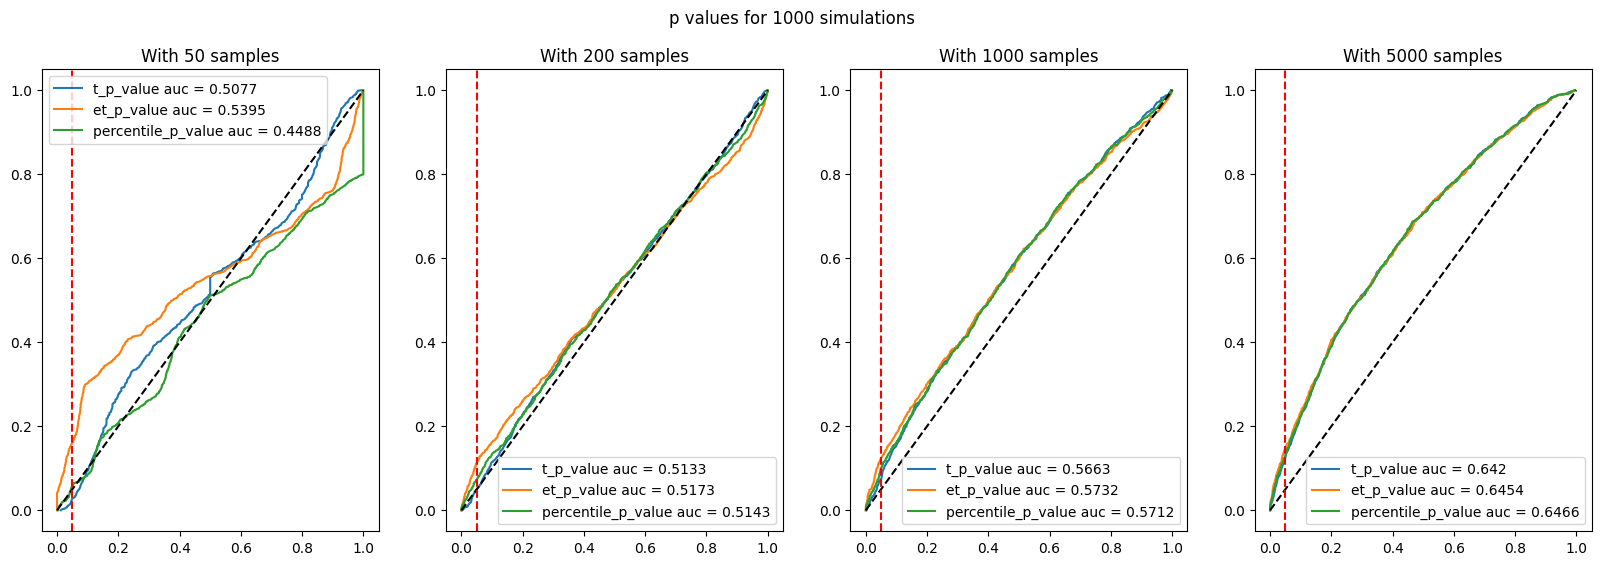

In [167]:
fig, ax = plt.subplots(1,len(samples), figsize=(20, 6))
fig.suptitle(f"p values for {experiments} simulations")

for i, s in enumerate(samples):
    data = p_values_AB_i[p_values_AB_i["samples"]==s]
    for t in ["t_p_value", "et_p_value", "percentile_p_value"]:
        auc_value = auc(sorted(data[t]), np.linspace(0, 1, experiments))
        ax[i].plot(sorted(data[t]), np.linspace(0, 1, experiments), label=f"{t} auc = {round(auc_value, 4)}")

    ax[i].set_title(f"With {s} samples")
    ax[i].legend()
    ax[i].plot([0,1],[0,1], '--k')
    ax[i].axvline(0.05, ls='--', color="red")

##### II. Effect 50%

In [168]:
experiments = 1000
samples = [50, 200, 1000, 5000]
p_values_AB_ii = pd.DataFrame()

for s in samples:
    this_p_values = run_test_mean_diff_multiple(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=experiments, num_samples=s, alternative="greater", effect=.5)
    this_p_values = this_p_values.reset_index(drop=True)
    this_p_values["samples"] = s 
    p_values_AB_ii = pd.concat([p_values_AB_ii, this_p_values])

p_values_AB_ii

,test_number,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null,samples
0,0,-0.087368,0.534629,False,0.659,False,0.657,False,50
1,1,-0.665446,0.745525,False,0.759,False,0.773,False,50
2,2,0.970258,0.168391,False,0.138,False,0.148,False,50
3,3,1.045449,0.150526,False,0.147,False,0.095,False,50
4,4,1.188838,0.120176,False,0.118,False,0.030,True,50
...,...,...,...,...,...,...,...,...,...
995,995,2.852893,0.002175,True,0.002,True,0.001,True,5000
996,996,3.716482,0.000102,True,0.000,True,0.000,True,5000
997,997,1.931489,0.026740,True,0.025,True,0.022,True,5000
998,998,3.304458,0.000479,True,0.000,True,0.000,True,5000


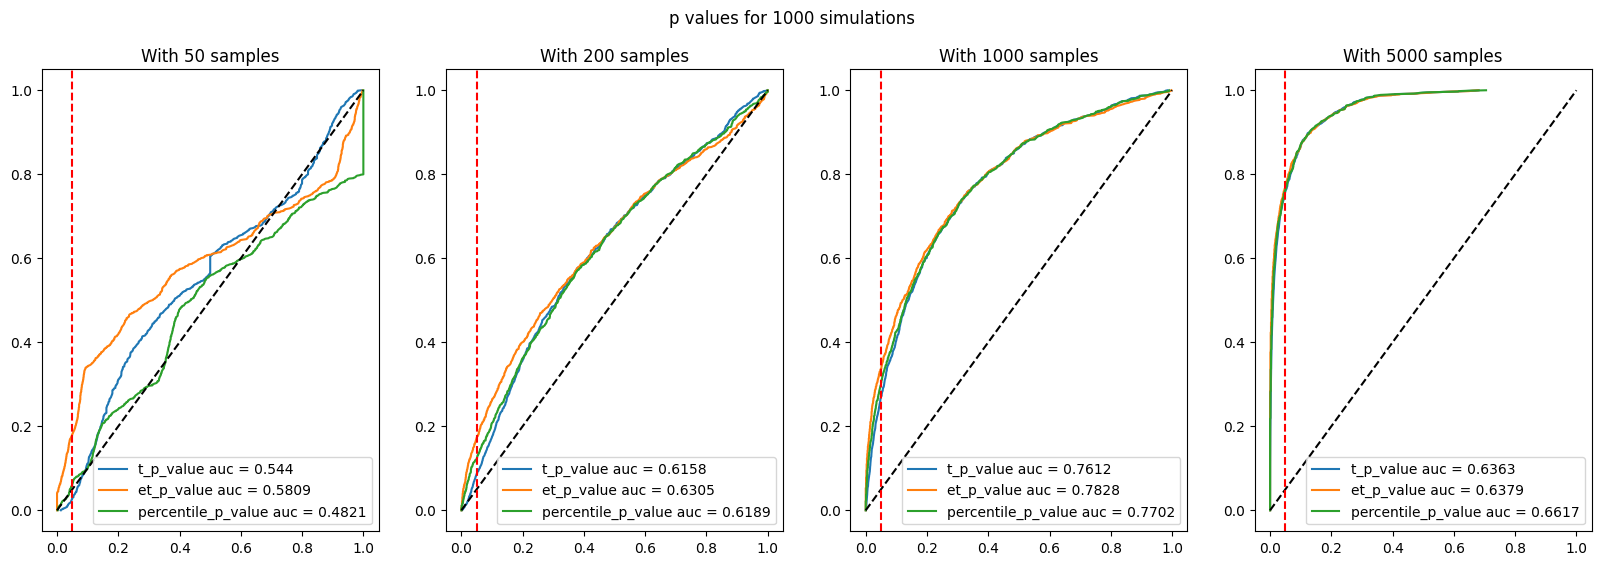

In [169]:
fig, ax = plt.subplots(1,len(samples), figsize=(20, 6))
fig.suptitle(f"p values for {experiments} simulations")

for i, s in enumerate(samples):
    data = p_values_AB_ii[p_values_AB_ii["samples"]==s]
    for t in ["t_p_value", "et_p_value", "percentile_p_value"]:
        auc_value = auc(sorted(data[t]), np.linspace(0, 1, experiments))
        ax[i].plot(sorted(data[t]), np.linspace(0, 1, experiments), label=f"{t} auc = {round(auc_value, 4)}")

    ax[i].set_title(f"With {s} samples")
    ax[i].legend()
    ax[i].plot([0,1],[0,1], '--k')
    ax[i].axvline(0.05, ls='--', color="red")

##### III. Effect 100%

In [172]:
experiments = 1000
samples = [50, 200, 1000, 5000]
p_values_AB_iii = pd.DataFrame()

for s in samples:
    this_p_values = run_test_mean_diff_multiple(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=experiments, num_samples=s, alternative="greater", effect=1)
    this_p_values = this_p_values.reset_index(drop=True)
    this_p_values["samples"] = s 
    p_values_AB_iii = pd.concat([p_values_AB_iii, this_p_values])

p_values_AB_iii

,test_number,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null,samples
0,0,0.108893,4.568706e-01,False,0.460,False,0.343,False,50
1,1,-0.376326,6.458335e-01,False,0.649,False,0.659,False,50
2,2,1.112296,1.357753e-01,False,0.102,False,0.093,False,50
3,3,1.182652,1.213861e-01,False,0.118,False,0.059,False,50
4,4,1.188838,1.201758e-01,False,0.118,False,0.030,True,50
...,...,...,...,...,...,...,...,...,...
995,995,4.283416,9.374990e-06,True,0.000,True,0.000,True,5000
996,996,5.183457,1.131935e-07,True,0.000,True,0.000,True,5000
997,997,3.288099,5.078198e-04,True,0.000,True,0.000,True,5000
998,998,4.479810,3.818787e-06,True,0.000,True,0.000,True,5000


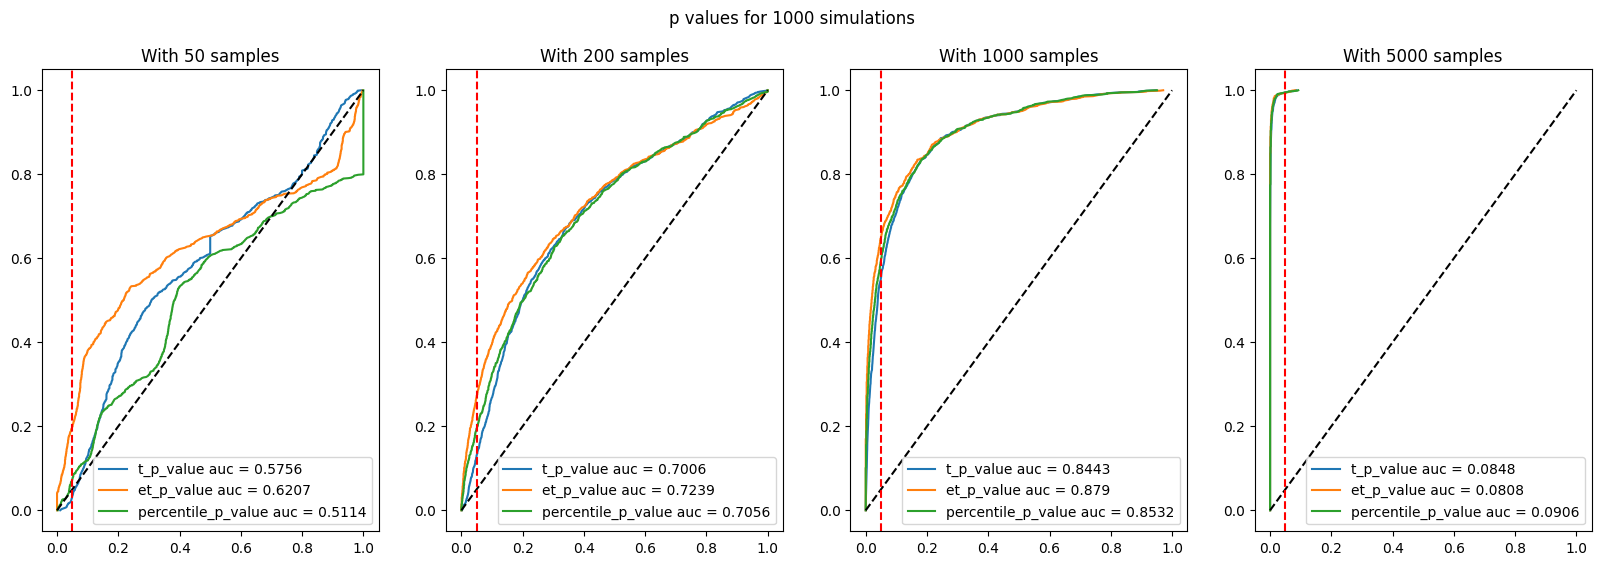

In [173]:
fig, ax = plt.subplots(1,len(samples), figsize=(20, 6))
fig.suptitle(f"p values for {experiments} simulations")

for i, s in enumerate(samples):
    data = p_values_AB_iii[p_values_AB_iii["samples"]==s]
    for t in ["t_p_value", "et_p_value", "percentile_p_value"]:
        auc_value = auc(sorted(data[t]), np.linspace(0, 1, experiments))
        ax[i].plot(sorted(data[t]), np.linspace(0, 1, experiments), label=f"{t} auc = {round(auc_value, 4)}")

    ax[i].set_title(f"With {s} samples")
    ax[i].legend()
    ax[i].plot([0,1],[0,1], '--k')
    ax[i].axvline(0.05, ls='--', color="red")

## Conclusion
There seem to be no improvement in AA test, con the studentized bootstrap (et) appearing to be worse than the others. 
For AB tests the bootstrap seem to have greater power at lower samples, with the studentized outperforming the percentile as forecasted. Nonetheless, the difference is very low and could only be useful under very little samples and huge changes, which would not be practical.